In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from arch import arch_model

In [2]:
# Download VIX data and other variables
vix = yf.download("^VIX", start="2010-01-01", end="2024-01-01")
vix = vix[['Adj Close']]
vix.rename(columns={'Adj Close': 'VIX'}, inplace=True)

[*********************100%***********************]  1 of 1 completed
/var/folders/1k/chl4s9pj7kq34vsddbkzt3480000gn/T/ipykernel_99955/2626041142.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix.rename(columns={'Adj Close': 'VIX'}, inplace=True)


In [3]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(vix)
adf_results = {
    "Test Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Lags Used": adf_test[2],
    "Number of Observations": adf_test[3],
    "Critical Values": adf_test[4]
}

# Display ADF Test results
print("ADF Test Results:")
for key, value in adf_results.items():
    print(f"{key}: {value}")

ADF Test Results:
Test Statistic: -4.978939279102182
p-value: 2.442467940324495e-05
Lags Used: 26
Number of Observations: 3495
Critical Values: {'1%': -3.432222420418919, '5%': -2.8623673289621894, '10%': -2.567210401636509}


In [4]:
pd.DataFrame(adf_results)

,Test Statistic,p-value,Lags Used,Number of Observations,Critical Values
1%,-4.978939,0.000024,26,3495,-3.432222
5%,-4.978939,0.000024,26,3495,-2.862367
10%,-4.978939,0.000024,26,3495,-2.567210


### Variable 1 - Lagged 1 VIX Values

<Figure size 1000x600 with 0 Axes>

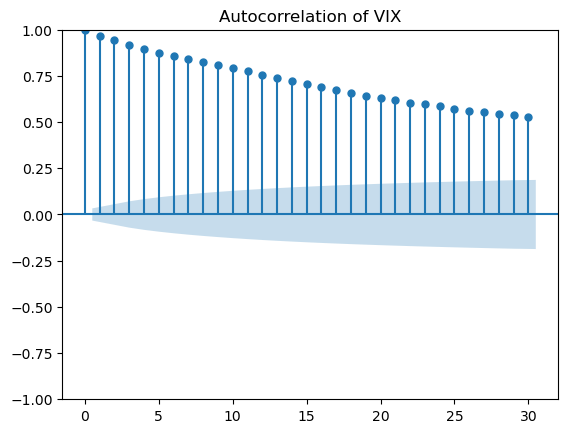

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation of VIX to observe how lagged values are related
plt.figure(figsize=(10,6))
plot_acf(vix, lags=30)  # Show autocorrelations for 30 lags
plt.title("Autocorrelation of VIX")
plt.show()

/Users/yuanqisun/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

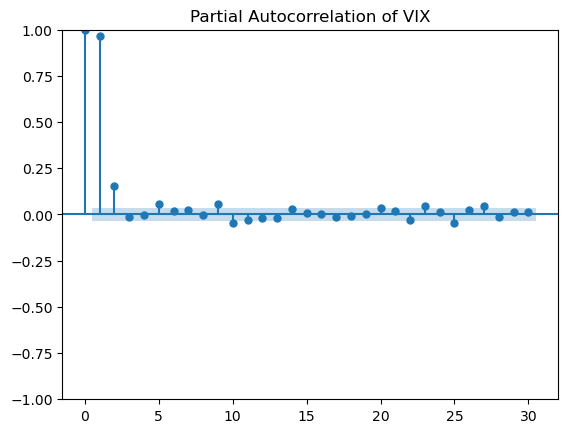

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot the partial autocorrelation of VIX to observe significant lag relationships
plt.figure(figsize=(10,6))
plot_pacf(vix, lags=30)
plt.title("Partial Autocorrelation of VIX")
plt.show()

In [7]:
lagvix = vix.shift(1)
lagvix.rename(columns={'VIX': 'LagVIX'}, inplace=True)
data = pd.concat([vix, lagvix], axis=1).dropna()
data

,VIX,LagVIX
Date,,
2010-01-05,19.350000,20.040001
2010-01-06,19.160000,19.350000
2010-01-07,19.059999,19.160000
2010-01-08,18.129999,19.059999
2010-01-11,17.549999,18.129999
...,...,...
2023-12-22,13.030000,13.650000
2023-12-26,12.990000,13.030000
2023-12-27,12.430000,12.990000


### Varible 2 -  Squared Residuals

In [8]:
sp500 = yf.download("^GSPC", start="2010-01-01", end="2024-01-01")

# Calculate daily returns of S&P 500 as a proxy for market fluctuations
sp500['Returns'] = sp500['Adj Close'].pct_change().dropna()
sp500['Squared_Returns'] = sp500['Returns']**2

[*********************100%***********************]  1 of 1 completed


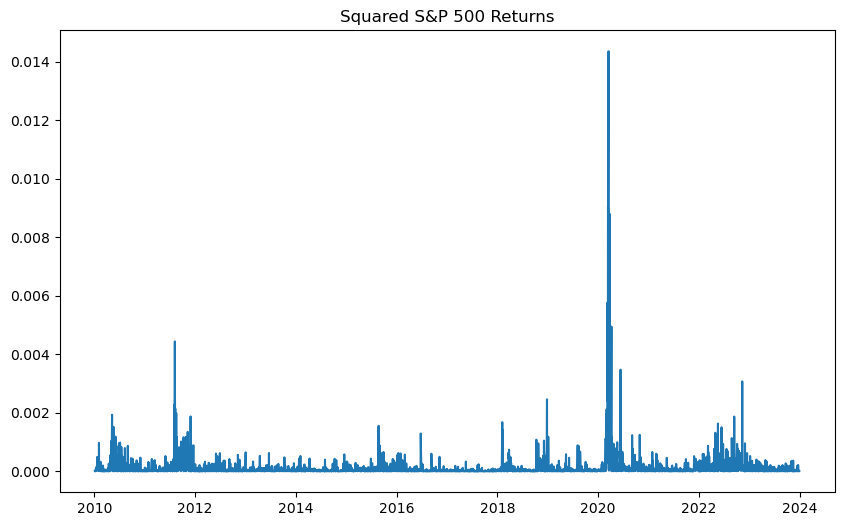

In [9]:
# Plot squared residuals
plt.figure(figsize=(10,6))
plt.plot(sp500['Squared_Returns'])
plt.title("Squared S&P 500 Returns")
plt.show()

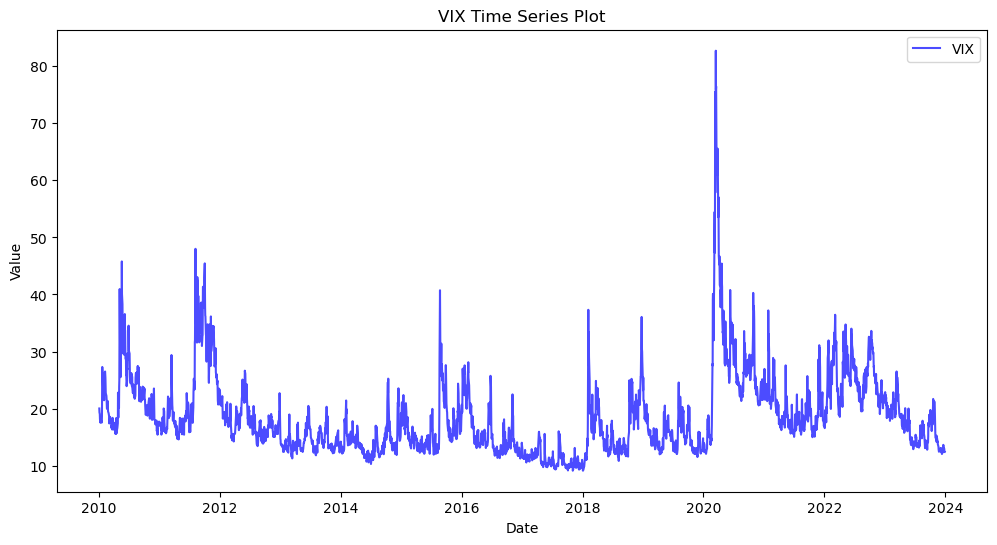

In [10]:
plt.figure(figsize=(12,6))

# Plot VIX spikes
plt.plot(vix, label='VIX', color='blue', alpha=0.7)
plt.title("VIX Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Value")

# Add legend to differentiate between the two lines
plt.legend()

# Show the plot
plt.show()

In [11]:
data = pd.concat([data, sp500['Squared_Returns']], axis=1).dropna()
data

,VIX,LagVIX,Squared_Returns
Date,,,
2010-01-05,19.350000,20.040001,9.707435e-06
2010-01-06,19.160000,19.350000,2.975928e-07
2010-01-07,19.059999,19.160000,1.600962e-05
2010-01-08,18.129999,19.059999,8.304352e-06
2010-01-11,17.549999,18.129999,3.051155e-06
...,...,...,...
2023-12-22,13.030000,13.650000,2.755794e-06
2023-12-26,12.990000,13.030000,1.790720e-05
2023-12-27,12.430000,12.990000,2.046209e-06


In [12]:
from arch import arch_model

from sklearn.preprocessing import StandardScaler

# Assuming 'data' contains your VIX, Oil Price, SP500 Volume, and other variables
scaler = StandardScaler()

# Standardize the relevant columns (VIX, Oil_Price, SP500_Volume, etc.)
data[['VIX','Squared_Returns']] = scaler.fit_transform(data[['VIX','Squared_Returns']])

garch_model = arch_model(10*data['VIX'], vol='Garch', p=1, q=1, mean='ARX', lags=1, x=data['Squared_Returns'])
garch_result = garch_model.fit()

# Summary of the results
print(garch_result.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1.628318808438434e+17
Iteration:      2,   Func. Count:     23,   Neg. LLF: 33433.929481215164
Iteration:      3,   Func. Count:     33,   Neg. LLF: 3054299.19968505
Iteration:      4,   Func. Count:     43,   Neg. LLF: 7515418.005291212
Iteration:      5,   Func. Count:     51,   Neg. LLF: 8663.51519206539
Iteration:      6,   Func. Count:     59,   Neg. LLF: 7563.875218877376
Iteration:      7,   Func. Count:     67,   Neg. LLF: 10034.95866354783
Iteration:      8,   Func. Count:     76,   Neg. LLF: 7226.9234504537635
Iteration:      9,   Func. Count:     83,   Neg. LLF: 7646.240791438955
Iteration:     10,   Func. Count:     91,   Neg. LLF: 7256.382581554124
Iteration:     11,   Func. Count:     99,   Neg. LLF: 7225.860172045377
Iteration:     12,   Func. Count:    106,   Neg. LLF: 7225.855781709633
Iteration:     13,   Func. Count:    113,   Neg. LLF: 7225.855612437936
Iteration:     14,   Func. Count:    120,   Neg. LLF: 7225.8

### Variable 3 - S&P500 Trading Volume^2

In [13]:
data = pd.concat([data, sp500['Volume']], axis=1).dropna()
data

,VIX,LagVIX,Squared_Returns,Volume
Date,,,,
2010-01-05,0.109099,20.040001,-0.245227,2491020000
2010-01-06,0.082378,19.350000,-0.265788,4972660000
2010-01-07,0.068314,19.160000,-0.231457,5270680000
2010-01-08,-0.062481,19.059999,-0.248293,4389590000
2010-01-11,-0.144052,18.129999,-0.259771,4255780000
...,...,...,...,...
2023-12-22,-0.779743,13.650000,-0.260417,3046770000
2023-12-26,-0.785368,13.030000,-0.227310,2513910000
2023-12-27,-0.864126,12.990000,-0.261967,2748450000


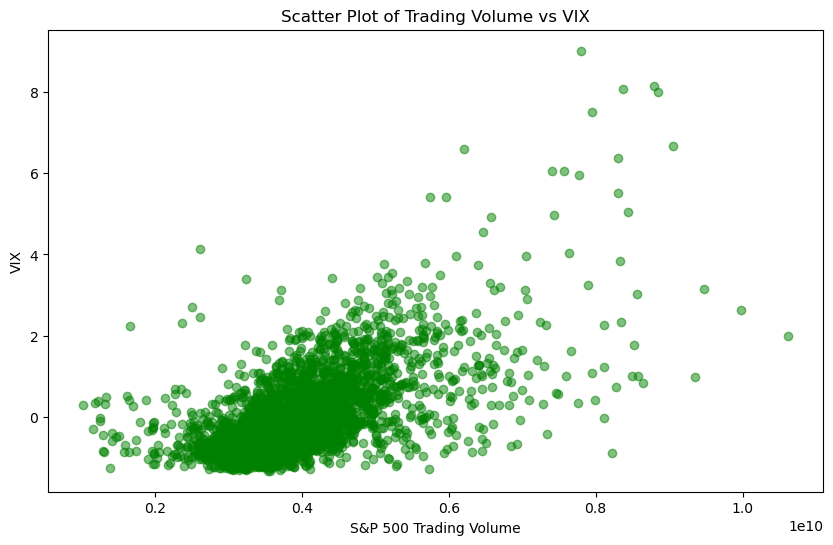

In [14]:
plt.figure(figsize=(10,6))
plt.scatter(data['Volume'], data['VIX'], alpha=0.5, c='green')

# Add titles and labels
plt.title("Scatter Plot of Trading Volume vs VIX")
plt.xlabel("S&P 500 Trading Volume")
plt.ylabel("VIX")

# Show the plot
plt.show()

In [15]:
scaler = StandardScaler()
data["Squared_SP500_Volume"] = data['Volume']**2

# Standardize the relevant columns (VIX, Oil_Price, SP500_Volume, etc.)
data[['VIX','Squared_SP500_Volume']] = scaler.fit_transform(data[['VIX','Squared_SP500_Volume']])

garch_model = arch_model(data['VIX'], vol='Garch', p=1, q=1, mean='ARX', lags=1, x=data['Squared_SP500_Volume'])
garch_result = garch_model.fit()

# Summary of the results
print(garch_result.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 70020232.9772686
Iteration:      2,   Func. Count:     22,   Neg. LLF: 2658117.900974499
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1229045.2904150262
Iteration:      4,   Func. Count:     46,   Neg. LLF: 2238.917670692508
Iteration:      5,   Func. Count:     54,   Neg. LLF: -182.54853157178076
Iteration:      6,   Func. Count:     62,   Neg. LLF: 194.0784046436322
Iteration:      7,   Func. Count:     70,   Neg. LLF: -124.70541296971007
Iteration:      8,   Func. Count:     78,   Neg. LLF: -718.1638494630873
Iteration:      9,   Func. Count:     85,   Neg. LLF: -716.853950399114
Iteration:     10,   Func. Count:     93,   Neg. LLF: 4190.04949068763
Iteration:     11,   Func. Count:    102,   Neg. LLF: -718.1605691693703
Iteration:     12,   Func. Count:    110,   Neg. LLF: -718.6195222091562
Iteration:     13,   Func. Count:    118,   Neg. LLF: -719.3995543705885
Iteration:     14,   Func. Count:    125,   Neg. LLF: -71

/Users/yuanqisun/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06578. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


### Variable 4 - Volatility of Oil 

[*********************100%***********************]  1 of 1 completed


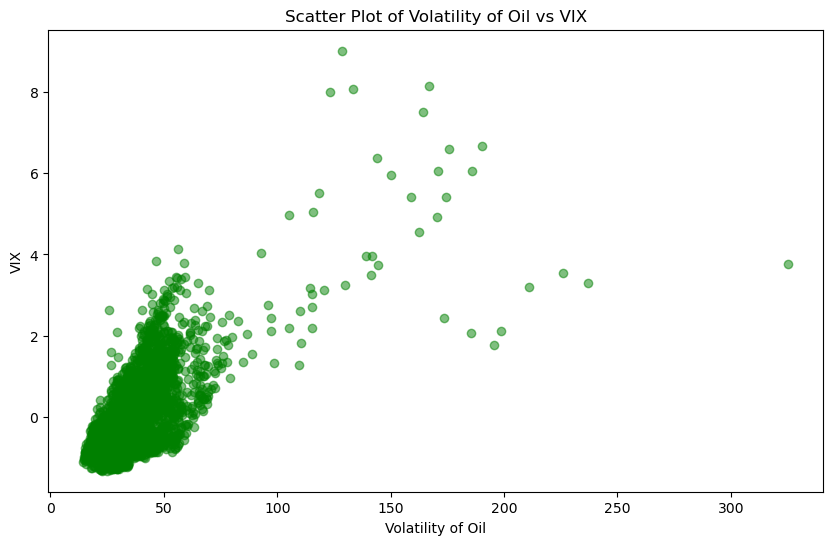

In [16]:
oil_vol = yf.download('^OVX', start='2010-01-01', end='2024-01-01')
data['Vol_Oil'] = oil_vol['Adj Close']

plt.figure(figsize=(10,6))
plt.scatter(data['Vol_Oil'], data['VIX'], alpha=0.5, c='green')

# Add titles and labels
plt.title("Scatter Plot of Volatility of Oil vs VIX")
plt.xlabel("Volatility of Oil")
plt.ylabel("VIX")

# Show the plot
plt.show()

In [17]:
from arch import arch_model

from sklearn.preprocessing import StandardScaler

# Assuming 'data' contains your VIX, Oil Price, SP500 Volume, and other variables
scaler = StandardScaler()

# Standardize the relevant columns (VIX, Oil_Price, SP500_Volume, etc.)
data[['VIX','Vol_Oil']] = scaler.fit_transform(data[['VIX','Vol_Oil']])

garch_model = arch_model(data['VIX'], vol='Garch', p=1, q=1, mean='ARX', lags=1, x=data['Vol_Oil'])
garch_result = garch_model.fit()

# Summary of the results
print(garch_result.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 23389243.908625517
Iteration:      2,   Func. Count:     23,   Neg. LLF: 76984.78362165931
Iteration:      3,   Func. Count:     36,   Neg. LLF: 305479.88597121014
Iteration:      4,   Func. Count:     48,   Neg. LLF: 9798.003104090449
Iteration:      5,   Func. Count:     56,   Neg. LLF: -234.73143188589847
Iteration:      6,   Func. Count:     64,   Neg. LLF: 674.8371146763282
Iteration:      7,   Func. Count:     73,   Neg. LLF: -720.7881878645046
Iteration:      8,   Func. Count:     80,   Neg. LLF: -693.6213296056095
Iteration:      9,   Func. Count:     88,   Neg. LLF: 2124.238366507014
Iteration:     10,   Func. Count:     97,   Neg. LLF: -721.3527682696264
Iteration:     11,   Func. Count:    105,   Neg. LLF: -716.8708360330945
Iteration:     12,   Func. Count:    113,   Neg. LLF: -722.9425761387594
Iteration:     13,   Func. Count:    120,   Neg. LLF: -722.942601498819
Iteration:     14,   Func. Count:    127,   Neg. LLF: -

/Users/yuanqisun/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06531. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


### Variable 5 - Unemployment Rate^2

In [18]:
gold_data = yf.download("GC=F", start="2010-01-01", end="2024-01-01")  # Gold Futures
gold_data = gold_data["Adj Close"].pct_change().abs().dropna().rename("GoldVolatility")
data = pd.concat([data, gold_data], axis=1).dropna()
data

[*********************100%***********************]  1 of 1 completed


,VIX,LagVIX,Squared_Returns,Volume,Squared_SP500_Volume,Vol_Oil,GoldVolatility
Date,,,,,,,
2010-01-05,0.109099,20.040001,-0.245227,2491020000,1.549822,-0.172784,0.000358
2010-01-06,0.082378,19.350000,-0.265788,4972660000,1.564179,-0.165348,0.015920
2010-01-07,0.068314,19.160000,-0.231457,5270680000,-1.365990,-0.210534,0.002465
2010-01-08,-0.062481,19.059999,-0.248293,4389590000,0.525117,-0.340373,0.004501
2010-01-11,-0.144052,18.129999,-0.259771,4255780000,0.304919,-0.417019,0.010982
...,...,...,...,...,...,...,...
2023-12-22,-0.779743,13.650000,-0.260417,3046770000,-1.375606,-0.227122,0.008827
2023-12-26,-0.785368,13.030000,-0.227310,2513910000,1.571629,-0.157912,0.000535
2023-12-27,-0.864126,12.990000,-0.261967,2748450000,1.806558,-0.107578,0.011515


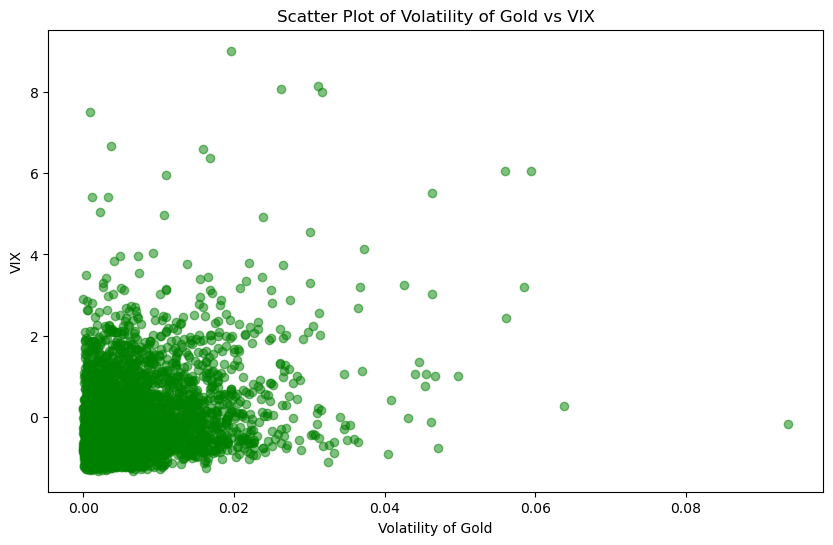

In [19]:
plt.figure(figsize=(10,6))
plt.scatter(data['GoldVolatility'], data['VIX'], alpha=0.5, c='green')

# Add titles and labels
plt.title("Scatter Plot of Volatility of Gold vs VIX")
plt.xlabel("Volatility of Gold")
plt.ylabel("VIX")

# Show the plot
plt.show()

In [20]:
garch_model = arch_model(data['VIX'], vol='Garch', p=1, q=1, mean='ARX', lags=1, x=data['GoldVolatility'])
garch_result = garch_model.fit()

# Display the results
print(garch_result.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 26243760.674301144
Iteration:      2,   Func. Count:     22,   Neg. LLF: 834545.5029845146
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3244375.229669464
Iteration:      4,   Func. Count:     42,   Neg. LLF: 5659.834244985074
Iteration:      5,   Func. Count:     51,   Neg. LLF: -244.59303144242887
Iteration:      6,   Func. Count:     59,   Neg. LLF: 1008.768542999612
Iteration:      7,   Func. Count:     68,   Neg. LLF: -724.2717219721546
Iteration:      8,   Func. Count:     76,   Neg. LLF: -716.4838077030582
Iteration:      9,   Func. Count:     84,   Neg. LLF: -731.3872182340685
Iteration:     10,   Func. Count:     91,   Neg. LLF: 3743649.4651887114
Iteration:     11,   Func. Count:    101,   Neg. LLF: -730.1974931607801
Iteration:     12,   Func. Count:    109,   Neg. LLF: -732.0250822430838
Iteration:     13,   Func. Count:    116,   Neg. LLF: -732.0268225672908
Iteration:     14,   Func. Count:    123,   Neg. LLF: 

/Users/yuanqisun/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06558. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [21]:
data

,VIX,LagVIX,Squared_Returns,Volume,Squared_SP500_Volume,Vol_Oil,GoldVolatility
Date,,,,,,,
2010-01-05,0.109099,20.040001,-0.245227,2491020000,1.549822,-0.172784,0.000358
2010-01-06,0.082378,19.350000,-0.265788,4972660000,1.564179,-0.165348,0.015920
2010-01-07,0.068314,19.160000,-0.231457,5270680000,-1.365990,-0.210534,0.002465
2010-01-08,-0.062481,19.059999,-0.248293,4389590000,0.525117,-0.340373,0.004501
2010-01-11,-0.144052,18.129999,-0.259771,4255780000,0.304919,-0.417019,0.010982
...,...,...,...,...,...,...,...
2023-12-22,-0.779743,13.650000,-0.260417,3046770000,-1.375606,-0.227122,0.008827
2023-12-26,-0.785368,13.030000,-0.227310,2513910000,1.571629,-0.157912,0.000535
2023-12-27,-0.864126,12.990000,-0.261967,2748450000,1.806558,-0.107578,0.011515


In [22]:
data_train = data[["VIX", "LagVIX", "Squared_Returns", "Squared_SP500_Volume", "Vol_Oil", "GoldVolatility"]]
scaler = StandardScaler()

# Standardize the relevant columns (VIX, Oil_Price, SP500_Volume, etc.)
data_train = scaler.fit_transform(data_train)

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

# Step 3: Train-Test Split
split_index = int(0.8 * len(data))
train_data, test_data = data.iloc[:split_index], data.iloc[split_index:]

In [24]:
from arch import arch_model

param_grid = {
    'volatility_model': ['Garch', 'EGarch'],  # Volatility models to test
    'p': range(1, 6),  # GARCH terms
    'q': range(1, 6)   # ARCH terms
}

# Correcting the exogenous variables setup
def fit_model_with_param_grid(y_train, X_train, param_grid):
    best_model = None
    best_score = float('inf')
    results = []

    # Iterate over all parameter combinations
    for params in ParameterGrid(param_grid):
        try:
            # Initialize the model
            model = arch_model(
                y_train,
                x=X_train,
                vol=params['volatility_model'],  # GARCH or EGARCH
                p=params['p'],
                q=params['q'],
                mean='ARX'  # Include exogenous variables
            )
            
            # Fit the model
            fitted_model = model.fit(disp="off")
            
            # Evaluate AIC
            aic = fitted_model.aic
            results.append((params['volatility_model'], params['p'], params['q'], aic))
            
            # Update the best model if AIC improves
            if aic < best_score:
                best_score = aic
                best_model = fitted_model
        except Exception as e:
            print(f"Error with parameters {params}: {e}")
            continue

    # Return the best model and results as a DataFrame
    results_df = pd.DataFrame(results, columns=['Volatility Model', 'p', 'q', 'AIC'])
    return best_model, results_df

# Fit GARCH model
print("Fitting GARCH with exogenous variables...")
y_train = 10*train_data['VIX']
X_train = train_data[["LagVIX", "Squared_Returns", "Squared_SP500_Volume", "Vol_Oil", "GoldVolatility"]]
best_model, results_df = fit_model_with_param_grid(y_train, X_train, param_grid)

# # Fit EGARCH model
# print("Fitting EGARCH with exogenous variables...")
# best_egarch_model, egarch_results = fit_model_with_param_grid('EGarch', y_train, X_train, param_grid)

# Define the forecast function
def forecast_with_exogenous(model, y_test, X_test):
    if model.model.x is None:
        raise ValueError("Model does not contain exogenous variables.")

    horizon = len(y_test)  # Forecast horizon is the size of the test set
    # Align forecast inputs
    forecast = model.forecast(horizon=horizon, x=X_test)
    predicted = forecast.mean.iloc[-horizon:].values.flatten()
    return predicted, y_test.values

# Forecast with GARCH
print("Forecasting with GARCH...")
y_test = 10*test_data['VIX']
X_test = test_data[["LagVIX", "Squared_Returns", "Squared_SP500_Volume", "Vol_Oil", "GoldVolatility"]]
X_test_dict = {col: X_test[col].values for col in X_test.columns}

# Forecast with the model
forecast = best_model.forecast(horizon=len(y_test), x=X_test_dict)

# Extract predicted values
predicted_scaled = forecast.mean.iloc[-len(y_test):].values.flatten()

Fitting GARCH with exogenous variables...
Forecasting with GARCH...


In [25]:
# Rescale predictions back to the original scale
predicted = predicted_scaled
# # Forecast with EGARCH
# print("Forecasting with EGARCH...")
# egarch_predicted, egarch_actual = forecast_with_exogenous(best_egarch_model, y_test, X_test)

# Evaluate the forecast performance
def evaluate_forecast(predicted, actual):
    mse = np.mean((predicted - actual) ** 2)
    return mse

mse = evaluate_forecast(predicted, y_test.values)

# Print Results
print("MSE:", mse)

MSE: 4.4208093701978095


In [26]:
best_model.params

Const                  -2.420811e+01
LagVIX                  1.288248e+00
Squared_Returns         1.657995e+00
Squared_SP500_Volume    8.043113e-02
Vol_Oil                 1.711648e-01
GoldVolatility          1.858699e+01
omega                   5.975498e-01
alpha[1]                3.368801e-01
alpha[2]                2.463283e-01
alpha[3]                1.444614e-01
beta[1]                 2.352815e-10
beta[2]                 1.389023e-01
beta[3]                 2.037711e-10
beta[4]                 1.334280e-01
Name: params, dtype: float64

In [27]:
best_model.summary

<bound method ARCHModelResult.summary of                           AR-X - GARCH Model Results                          
Dep. Variable:                    VIX   R-squared:                       0.938
Mean Model:                      AR-X   Adj. R-squared:                  0.938
Vol Model:                      GARCH   Log-Likelihood:               -5709.58
Distribution:                  Normal   AIC:                           11447.2
Method:            Maximum Likelihood   BIC:                           11530.4
                                        No. Observations:                 2814
Date:                Sun, Dec 01 2024   Df Residuals:                     2808
Time:                        14:40:46   Df Model:                            6
                                     Mean Model                                     
                           coef    std err          t      P>|t|    95.0% Conf. Int.
------------------------------------------------------------------------------

In [28]:
best_model

                          AR-X - GARCH Model Results                          
Dep. Variable:                    VIX   R-squared:                       0.938
Mean Model:                      AR-X   Adj. R-squared:                  0.938
Vol Model:                      GARCH   Log-Likelihood:               -5709.58
Distribution:                  Normal   AIC:                           11447.2
Method:            Maximum Likelihood   BIC:                           11530.4
                                        No. Observations:                 2814
Date:                Sun, Dec 01 2024   Df Residuals:                     2808
Time:                        14:40:46   Df Model:                            6
                                     Mean Model                                     
                           coef    std err          t      P>|t|    95.0% Conf. Int.
------------------------------------------------------------------------------------
Const                  -24.2081   

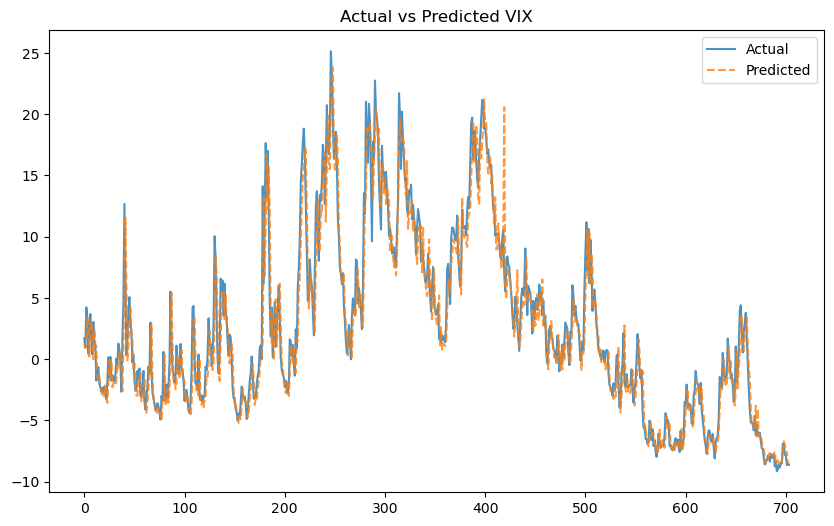

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual", alpha=0.8)
plt.plot(predicted, label="Predicted", linestyle="--", alpha=0.8)
plt.legend()
plt.title("Actual vs Predicted VIX")
plt.show()

In [30]:
mae = np.mean(np.abs(predicted - y_test.values))
print("MAE:", mae)

MAE: 1.4979541297221004


In [31]:
predicted_changes = np.diff(predicted_scaled)
actual_changes = np.diff(y_test.values)

# Identify the largest predicted and actual spikes
largest_predicted_spike = np.max(predicted_changes)
largest_actual_spike = np.max(actual_changes)

print(f"Largest Predicted Spike: {largest_predicted_spike}")
print(f"Largest Actual Spike: {largest_actual_spike}")

Largest Predicted Spike: 11.788275876469807
Largest Actual Spike: 14.120209958228088


/Users/yuanqisun/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


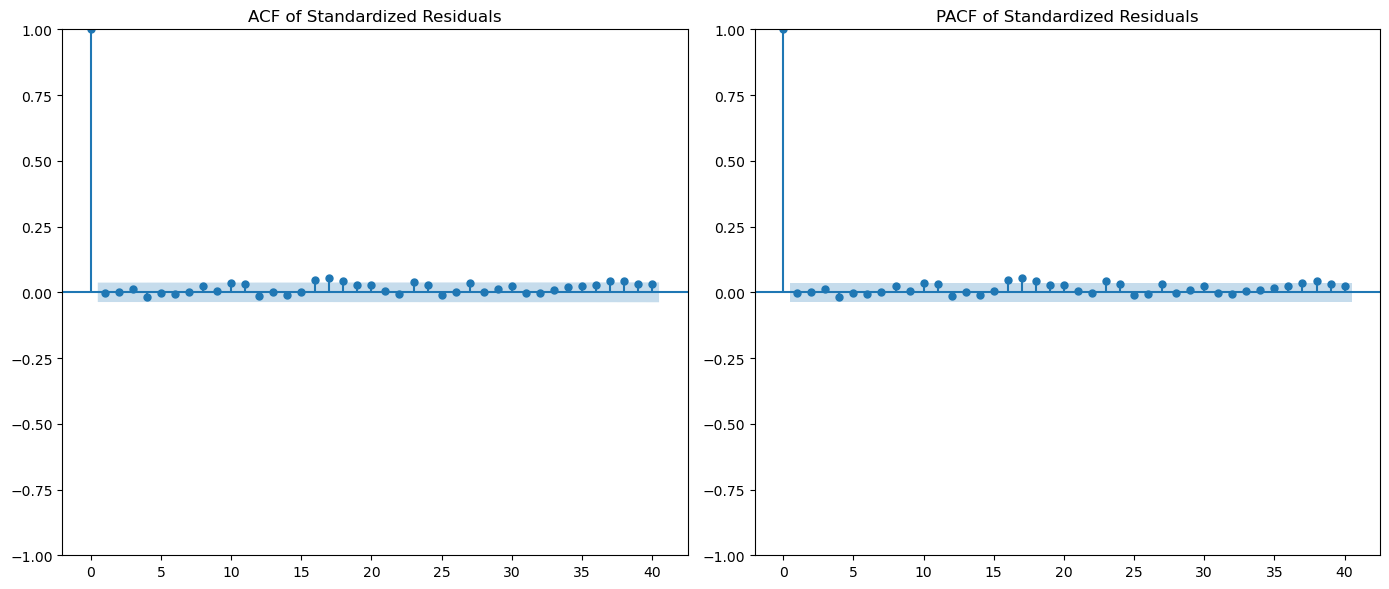

In [32]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import jarque_bera
import statsmodels.api as sm

standardized_residuals = best_model.resid / best_model.conditional_volatility

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sm.graphics.tsa.plot_acf(standardized_residuals, ax=axes[0], lags=40, title="ACF of Standardized Residuals")
sm.graphics.tsa.plot_pacf(standardized_residuals, ax=axes[1], lags=40, title="PACF of Standardized Residuals")
plt.tight_layout()
plt.show()